In [1]:
import os
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchmetrics import Accuracy,F1Score
import random

c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = Path("data/")
data_path.mkdir(parents=True,exist_ok=True)

In [3]:
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df = pd.DataFrame(image_list)

In [4]:
df.head()

,path,classes
0,data\Full Water level\Full Water level\-on-w...,Full Water level
1,data\Full Water level\Full Water level\01-wa...,Full Water level
2,data\Full Water level\Full Water level\0bnC0...,Full Water level
3,data\Full Water level\Full Water level\1-0l-...,Full Water level
4,data\Full Water level\Full Water level\1000_...,Full Water level


In [5]:
df.shape

(429, 2)

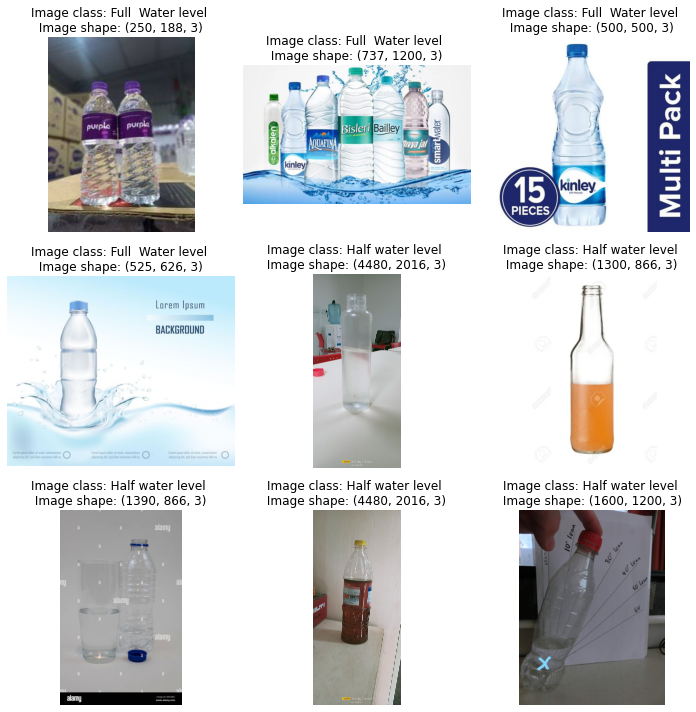

In [6]:
def plot_image(data):

    rnd_sample = df.sample(9)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, path in zip(axes, rnd_sample["path"]):
        img_class = rnd_sample[rnd_sample["path"] == path]["classes"].iloc[0]

        img = Image.open(path)
        img_as_array = np.array(img)
        ax.imshow(img_as_array)
        ax.set_title(f"Image class: {img_class} \n Image shape: {img_as_array.shape} ")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_image(df)


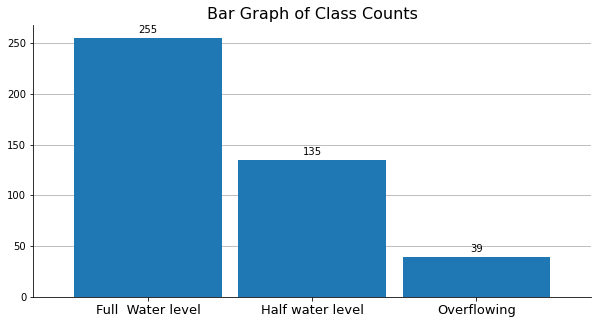

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Bar Graph of Class Counts", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")


#### We have imbalanced label.

In [8]:
df["classes"] = df["classes"].map(
    {
        "Full  Water level": "full",
        "Half water level": "half",
        "Overflowing": "Overflowing",
    }
)


In [9]:
df.head()

,path,classes
0,data\Full Water level\Full Water level\-on-w...,full
1,data\Full Water level\Full Water level\01-wa...,full
2,data\Full Water level\Full Water level\0bnC0...,full
3,data\Full Water level\Full Water level\1-0l-...,full
4,data\Full Water level\Full Water level\1000_...,full


In [10]:
from sklearn.model_selection import train_test_split


train_df,test_df = train_test_split(df,test_size=0.2,shuffle=True,random_state=42)

In [11]:
train_df.shape,test_df.shape

((343, 2), (86, 2))

In [12]:
def find_classes(data):
    # Get the class names by scanning the target directory
    classes = ["full", "half", "Overflowing"]
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx


In [13]:
find_classes(df)

(['full', 'half', 'Overflowing'], {'full': 0, 'half': 1, 'Overflowing': 2})

In [14]:
class CustomImageFolder(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(data)

    def __len__(self):
        return len(self.data)

    def load_image(self, idx: int) -> Image.Image:
        image_path = self.data.iloc[idx, 0]
        return Image.open(image_path)

    def __getitem__(self, idx):

        img = self.load_image(idx)

        class_name = self.data.iloc[idx, 1]
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_idx

        else:
            return img, class_idx


In [15]:
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


In [16]:
train_data_transformed = CustomImageFolder(train_df, transform=train_transform)
test_data_transformed = CustomImageFolder(test_df, transform=test_transform)


### Random image in train dataset

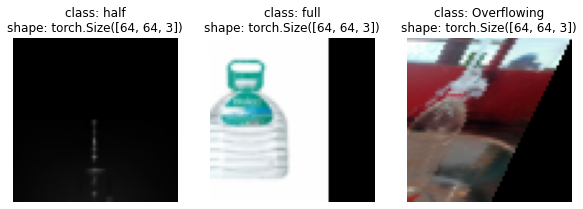

In [17]:
random_samples_idx = random.sample(range(len(train_data_transformed)), k=3)
classes = train_data_transformed.classes
plt.figure(figsize=(10, 10))
for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = (
        train_data_transformed[targ_sample][0],
        train_data_transformed[targ_sample][1],
    )
    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, 3, i + 1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    title = f"class: {classes[targ_label]}"

    title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


### Random image in test dataset

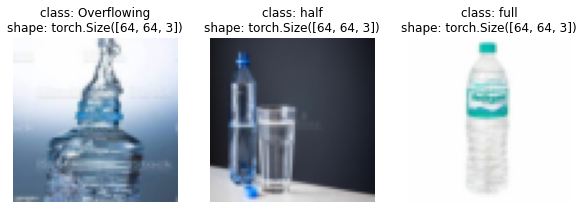

In [18]:
random_samples_idx = random.sample(range(len(test_data_transformed)), k=3)
classes = test_data_transformed.classes
plt.figure(figsize=(10, 10))
for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = (
        test_data_transformed[targ_sample][0],
        test_data_transformed[targ_sample][1],
    )
    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, 3, i + 1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    title = f"class: {classes[targ_label]}"

    title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


In [19]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data_transformed, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data_transformed, batch_size=BATCH_SIZE, shuffle=False)


In [20]:
img_batch, label_batch = next(iter(train_dataloader))
print(f"Image Shape: {img_batch.shape} -> [batch_size,color_channels,height,width]")
print(f"Label shape: {label_batch.shape}")


Image Shape: torch.Size([32, 3, 64, 64]) -> [batch_size,color_channels,height,width]
Label shape: torch.Size([32])


## Creating Baseline Model

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
import torch
from torch import nn

In [23]:
class WaterBottleV0(nn.Module):
    def __init__(self,input_shape:int,output_shape:int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=output_shape),
            nn.ReLU()

        )
    def forward(self,x):
        return self.block(x)

model_0 = WaterBottleV0(input_shape=12288,output_shape=3).to(device)  # input shape = 64x64x3


In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.01)
accuracy_fn = Accuracy(task="multiclass",num_classes=len(train_data_transformed.classes)).to(device)
f1_score_fn = F1Score(task="multiclass",num_classes=len(train_data_transformed.classes),average="macro").to(device)

In [25]:
def train_step(model,dataloader,loss_fn,optimizer,accuracy_fn,f1_score,device):
    
    model.train()
    train_loss,train_acc,train_f1_score=0,0,0

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred,y)
        train_f1_score += f1_score(y_pred,y)
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_f1_score /= len(dataloader)

    return train_loss,train_acc,train_f1_score

In [26]:
def test_step(model,dataloader,loss_fn,accuracy_fn,f1_score,device):
    model.eval()
    test_loss, test_acc,test_f1_score =0,0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss
            test_acc += accuracy_fn(y_pred,y)
            test_f1_score += f1_score(y_pred,y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        test_f1_score /= len(dataloader)

    return test_loss,test_acc,test_f1_score

In [27]:
from tqdm.auto import tqdm

In [28]:
def train(model,train_dataloader,test_dataloader,loss_fn,optimizer,epochs,device):
    results= {"train_loss": [],
            "train_acc":[],
            "train_f1_score":[],
            "test_loss":[],
            "test_acc":[],
            "test_f1_score":[]}

    for epoch in tqdm(range(epochs)):

        train_loss,train_acc,train_f1_score = train_step(model,train_dataloader,loss_fn,optimizer,accuracy_fn,f1_score_fn,device)
        test_loss,test_acc,test_f1_score = test_step(model,test_dataloader,loss_fn,accuracy_fn,f1_score_fn,device)

        if epoch % 4 == 0:

            print(
            f"Epoch: {epoch} \n "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {np.round(train_acc.item(),4)*100}% | "
            f"train_f1_score: {np.round(train_f1_score.item(),4)*100}% | \n "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {np.round(test_acc.item(),2)*100}% | "
            f"test_f1_score: {np.round(test_f1_score.item(),2)*100}%"
            )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss.cpu().detach().numpy())
        results["train_acc"].append(train_acc.cpu().detach().numpy())
        results["train_f1_score"].append(train_f1_score.cpu().detach().numpy())
        results["test_loss"].append(test_loss.cpu().detach().numpy())
        results["test_acc"].append(test_acc.cpu().detach().numpy())
        results["test_f1_score"].append(test_f1_score.cpu().detach().numpy())

    # 6. Return the filled results at the end of the epochs
    return results

In [29]:
# Train model_0 
NUM_EPOCHS = 16
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)
                        

  6%|▋         | 1/16 [00:13<03:21, 13.43s/it]

Epoch: 0 
 train_loss: 2.9789 | train_acc: 46.550000000000004% | train_f1_score: 20.630000000000003% | 
 test_loss: 1.1745 | test_acc: 63.0% | test_f1_score: 26.0%


 31%|███▏      | 5/16 [00:47<01:38,  8.98s/it]

Epoch: 4 
 train_loss: 1.0894 | train_acc: 58.989999999999995% | train_f1_score: 24.55% | 
 test_loss: 1.0886 | test_acc: 63.0% | test_f1_score: 26.0%


 56%|█████▋    | 9/16 [01:15<00:52,  7.48s/it]

Epoch: 8 
 train_loss: 1.0969 | train_acc: 58.440000000000005% | train_f1_score: 24.310000000000002% | 
 test_loss: 1.0873 | test_acc: 63.0% | test_f1_score: 26.0%


 81%|████████▏ | 13/16 [01:52<00:28,  9.49s/it]

Epoch: 12 
 train_loss: 1.0921 | train_acc: 58.660000000000004% | train_f1_score: 24.51% | 
 test_loss: 1.0872 | test_acc: 63.0% | test_f1_score: 26.0%


100%|██████████| 16/16 [02:16<00:00,  8.52s/it]


In [36]:
def plot_curves(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    train_f1_score = results["train_f1_score"]
    test_f1_score = results["test_f1_score"]
    epochs = range(len(train_loss))

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    fig.suptitle("Comparison of Training and Testing Metrics Over Epochs", fontsize=16)

    metric_names = [("loss", "Loss"), ("acc", "Accuracy"), ("f1_score", "F1 Score")]
    for ax, (metric, label) in zip(axes, metric_names):
        ax.plot(epochs, results[f"train_{metric}"], label=f"train {label}")
        ax.plot(epochs, results[f"test_{metric}"], label=f"test {label}")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(which="both", axis="y")
        ax.set_axisbelow(True)
        ax.set_xlabel("Epochs")
        ax.set_ylabel(label)
        ax.legend()

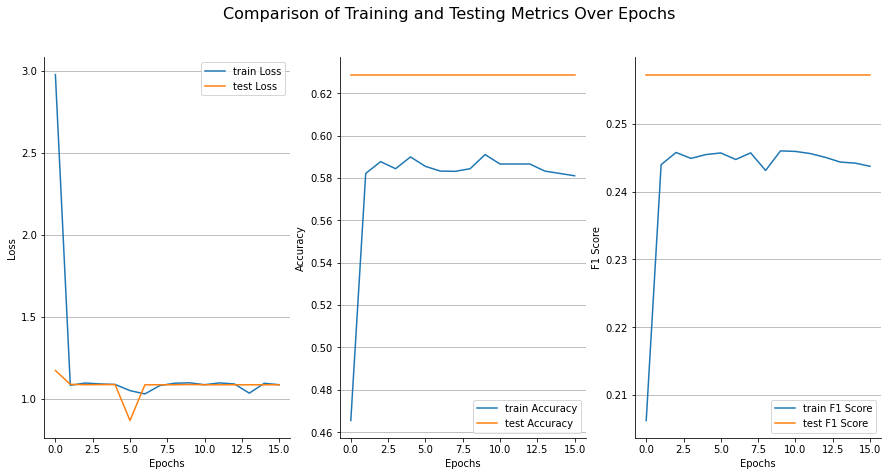

In [37]:
plot_curves(model_0_results)